# Part 4: Churn Prediction

Every company puts its efforts into knowing who their best customer are and then it also work hard on retaining them. That’s what makes **Retention Rate** is one of the most critical metrics.

Retention Rate is an indication of how good is your product market fit (PMF). If your PMF is not satisfactory, you should see your customers churning very soon. One of the powerful tools to improve Retention Rate (hence the PMF) is Churn Prediction. By using this technique, you can easily find out who is likely to churn in the given period. 

In this notebook, we will use a Telco dataset and go over following steps to develop churn prediction:
* Exploratory data analysis
* Feature engineering
* Investigating how the features affect Retention by using Logistic Regression
* Building a classification model with XGBoost

In [50]:
# import libraries
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

import growth_kit as gk

In [2]:
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis
We start with checking out how our data looks like and visualize how it interacts with our label (churned or not?). 

In [3]:
df_data = pd.read_csv('data/churn-data.csv')
df_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Our data fall under two categories:
* Categorical features: gender, streaming tv, payment method &, etc.
* Numerical features: tenure, monthly charges, total charges

Now starting from the categorical ones, we shed light on all features and see how helpful they are to identify if a customer is going to churn.

In [5]:
# convert churn label to integer 0-No, 1-Yes
df_data['Churn'] = df_data['Churn'].replace({"Yes": 1, "No": 0})

#### Gender
Let's start with how Churn rate looks with respect to Gender:

In [6]:
def plot_churn(data, category):
    # Chrun percentage and total count
    df_plot = df_data.groupby(category)['Churn'].agg(['mean', 'count']).reset_index()
    print(df_plot[[category, 'mean']])
    
    # Set up two plot figure
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8,8))
    
    # Churn Rate
    sns.barplot(x=category, y='mean', palette=sns.color_palette("OrRd", 3), data=df_plot, ax=axs[0])
    axs[0].set(xlabel=None, ylabel='Churn Rate', title='{} based Churn Rate'.format(category))
    
    # Count of customers in each group
    sns.barplot(x=category, y='count', palette=sns.color_palette("Blues"), data=df_plot, ax=axs[1])
    axs[1].set(xlabel=category, ylabel='Total Customers')
    plt.show()


   gender      mean
0  Female  0.269209
1    Male  0.261603


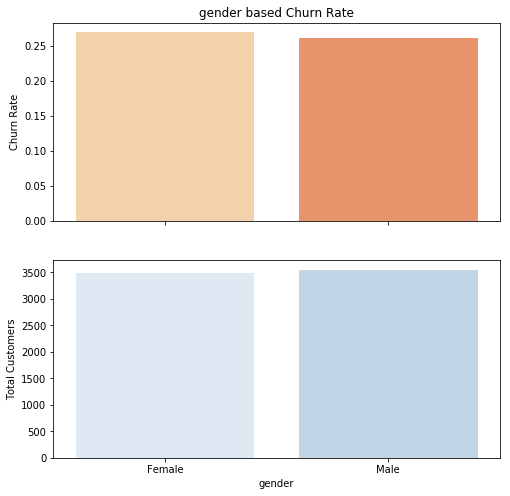

In [7]:
plot_churn(df_data, 'gender')

Female customers are more likely to churn vs. male customers, but the difference is minimal (~0.8%).

Let’s replicate this for all categorical columns.

#### InternetService

  InternetService      mean
0             DSL  0.189591
1     Fiber optic  0.418928
2              No  0.074050


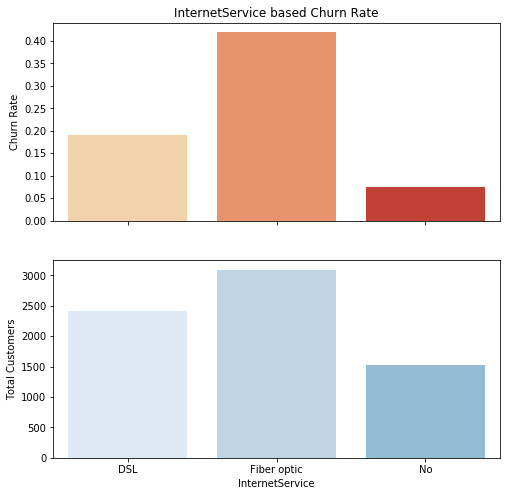

In [8]:
plot_churn(df_data, 'InternetService')

This chart reveals customers who have Fiber optic as Internet Service are more likely to churn. I normally expect Fiber optic customers to churn less due to they use a more premium service. But this can happen due to high prices, competition, customer service, and many other reasons.

#### Contract

         Contract      mean
0  Month-to-month  0.427097
1        One year  0.112695
2        Two year  0.028319


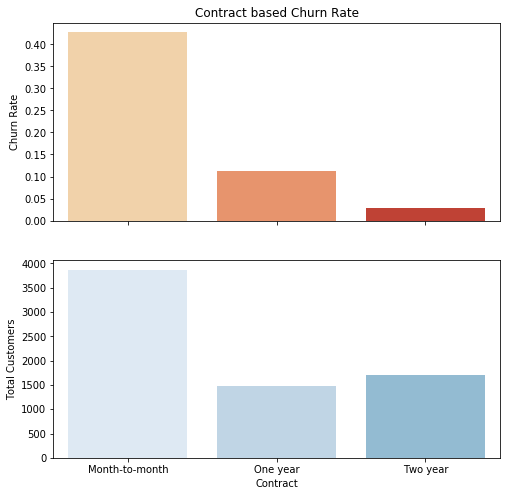

In [9]:
plot_churn(df_data, 'Contract')

As expected, the shorter contract means higher churn rate.

#### Tech Support

           TechSupport      mean
0                   No  0.416355
1  No internet service  0.074050
2                  Yes  0.151663


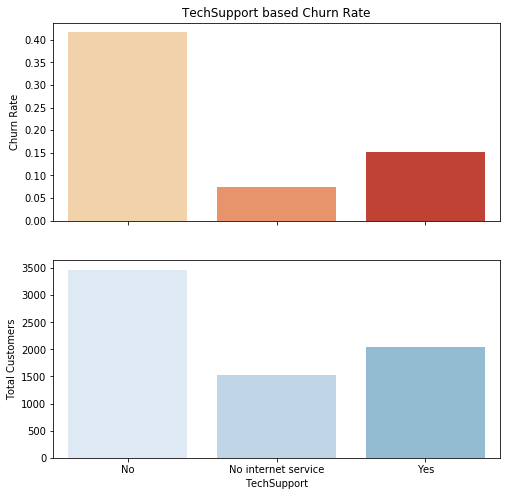

In [10]:
plot_churn(df_data, 'TechSupport')

Customers don’t use Tech Support are more like to churn (~25% difference).

#### Payment Method

               PaymentMethod      mean
0  Bank transfer (automatic)  0.167098
1    Credit card (automatic)  0.152431
2           Electronic check  0.452854
3               Mailed check  0.191067


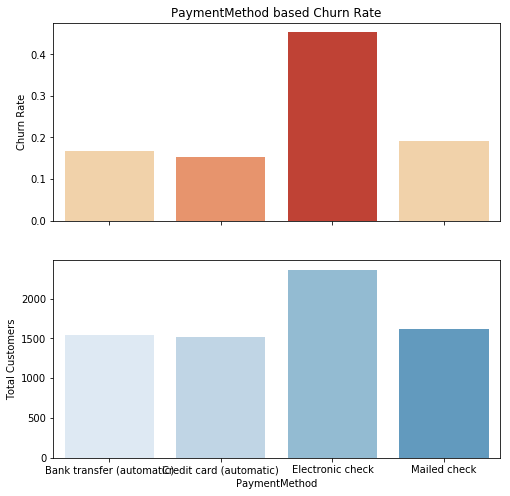

In [11]:
plot_churn(df_data, 'PaymentMethod')

Automating the payment makes the customer more likely to retain in your platform (~30% difference).

#### Others

  Partner      mean
0      No  0.329580
1     Yes  0.196649


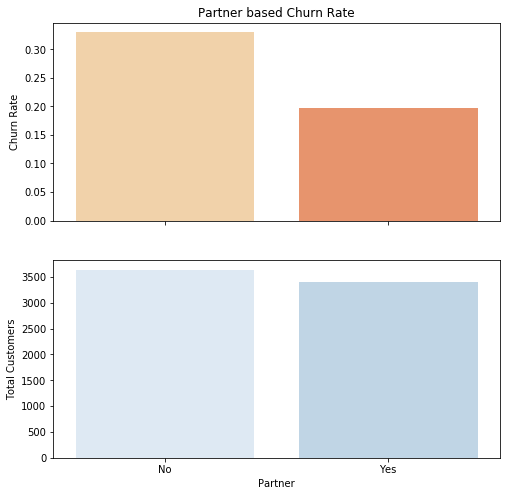

  PhoneService      mean
0           No  0.249267
1          Yes  0.267096


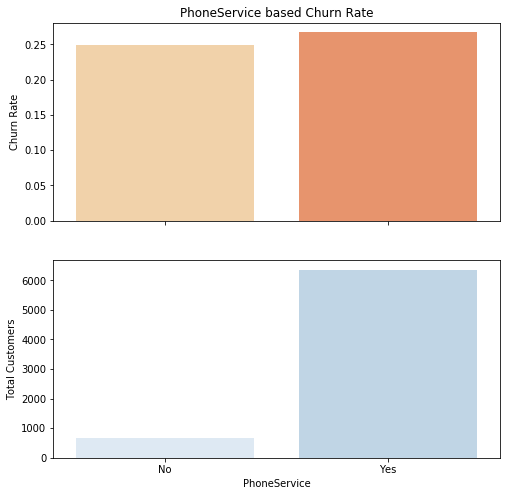

      MultipleLines      mean
0                No  0.250442
1  No phone service  0.249267
2               Yes  0.286099


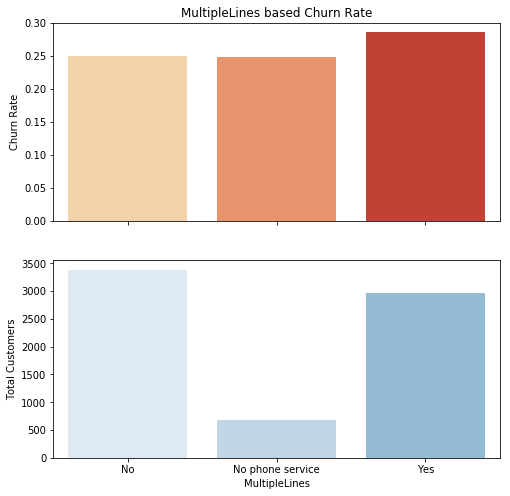

        OnlineSecurity      mean
0                   No  0.417667
1  No internet service  0.074050
2                  Yes  0.146112


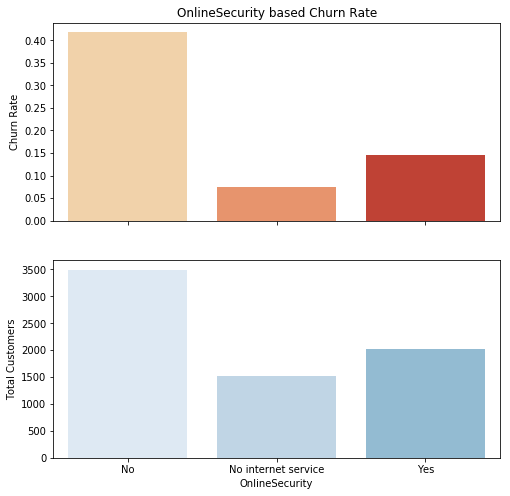

          OnlineBackup      mean
0                   No  0.399288
1  No internet service  0.074050
2                  Yes  0.215315


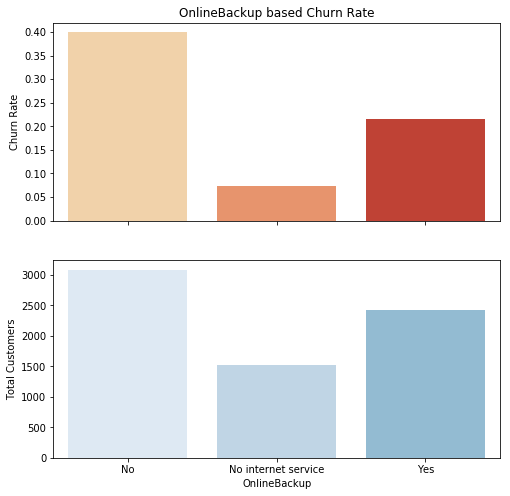

      DeviceProtection      mean
0                   No  0.391276
1  No internet service  0.074050
2                  Yes  0.225021


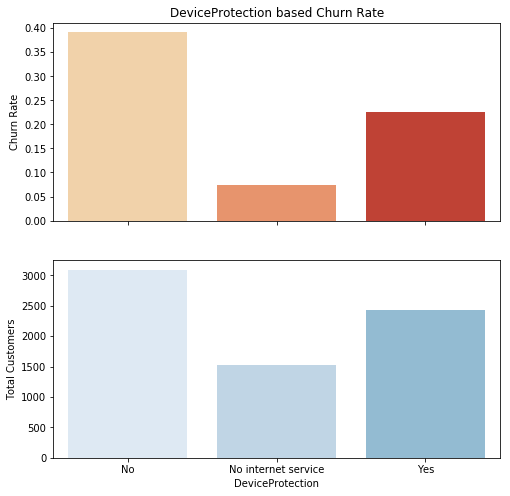

           StreamingTV      mean
0                   No  0.335231
1  No internet service  0.074050
2                  Yes  0.300702


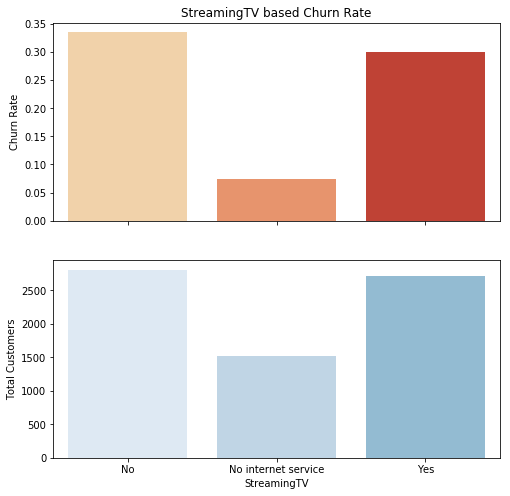

       StreamingMovies      mean
0                   No  0.336804
1  No internet service  0.074050
2                  Yes  0.299414


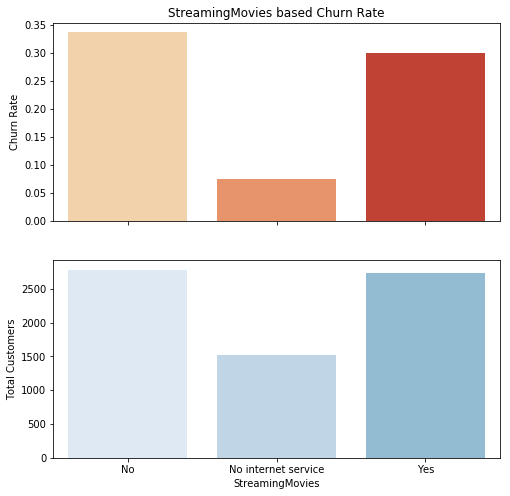

  PaperlessBilling      mean
0               No  0.163301
1              Yes  0.335651


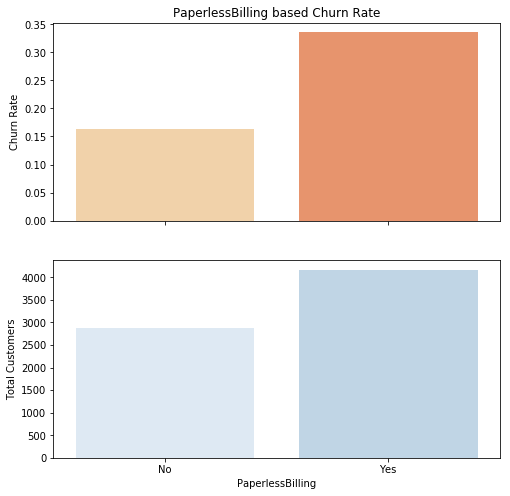

In [12]:
cat_columns = ['Partner', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
              'DeviceProtection', 'StreamingTV', 'StreamingMovies' ,'PaperlessBilling', ]

for col in cat_columns:
    plot_churn(df_data, col)

Other indicative columns are: Partner, Online Security, Online Backup, Paperless Billing.

We are done with the categorical features. Let’s see how numerical features look like.

#### Tenure

To see the trend between Tenure and average Churn Rate, let’s build a scatter plot:

[Text(0, 0.5, 'Churn Rate'), Text(0.5, 1.0, 'Tenure based Churn Rate')]

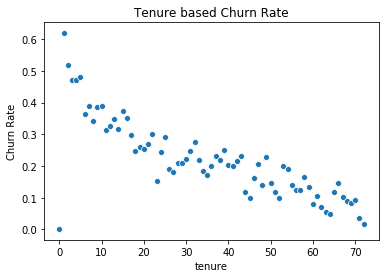

In [13]:
# tenure based churn rate
df_plot = df_data.groupby('tenure').Churn.mean().reset_index()
ax = sns.scatterplot(x='tenure', y='Churn', data=df_plot)
ax.set(title='Tenure based Churn Rate', ylabel='Churn Rate')

Super apparent that the higher tenure means lower Churn Rate. We are going to apply the same for Monthly and Total Charges.

#### Monthly Charges

In [14]:
df_data.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

[Text(0, 0.5, 'Churn Rate'), Text(0.5, 1.0, 'Monthly Charges vs. Churn Rate')]

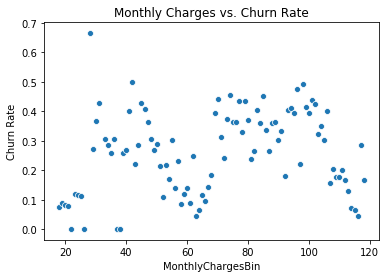

In [15]:
# monthly charge
df_plot = (df_data.assign(MonthlyChargesBin = lambda x: x['MonthlyCharges'].astype(int))
                  .groupby('MonthlyChargesBin')['Churn'].mean()
                  .reset_index())
ax = sns.scatterplot(x='MonthlyChargesBin', y='Churn', data=df_plot)
ax.set(title='Monthly Charges vs. Churn Rate', ylabel='Churn Rate')

#### Total Charges

In [16]:
pd.to_numeric(df_data['TotalCharges'], errors='coerce').dropna().astype(int).head()

0      29
1    1889
2     108
3    1840
4     151
Name: TotalCharges, dtype: int32

[Text(0, 0.5, 'Churn Rate'), Text(0.5, 1.0, 'Total Charges vs. Churn Rate')]

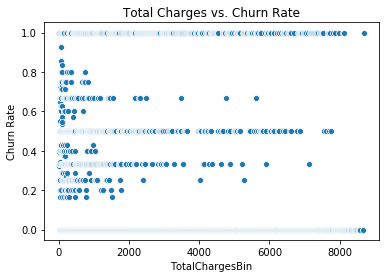

In [17]:
# total charge
df_plot = (df_data.assign(TotalChargesBin = lambda x: pd.to_numeric(x['TotalCharges'], errors='coerce'))
                    .dropna()
                    .astype({'TotalChargesBin': 'int32'})
                    .groupby('TotalChargesBin')['Churn'].mean()
                    .reset_index())
ax = sns.scatterplot(x='TotalChargesBin', y='Churn', data=df_plot)
ax.set(title='Total Charges vs. Churn Rate', ylabel='Churn Rate')

Unfortunately, there is no trend between Churn Rate and Monthly & Total Charges.

## Feature Engineering
In this section, we are going to transform our raw features to extract more information from them. Our strategy is as follows:
1. Group the numerical columns by using clustering techniques
1. Apply Label Encoder to categorical features which are binary
1. Apply get_dummies() to categorical features which have multiple value

### Numerical Columns
As we know from the EDA section, We have three numerical columns:
* Tenure
* Monthly Charges
* Total Charges

We are going to apply the following steps to create groups:
* Using Elbow Method to identify the appropriate number of clusters
* Applying K-means logic to the selected column and change the naming
* Observe the profile of clusters

#### Tenure Cluster

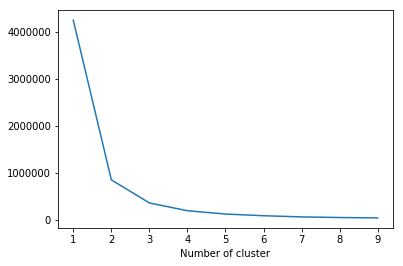

In [18]:
# check appopriate number of clusters
gk.elbow_method(df_data[['tenure']])

According to elbow method, for tenure we optimal choice is 3 clusters. We could go with other number if business requires so.

In [19]:
# calculate tenure cluster for each customer
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

# order cluster numbers in ascending order based on mean of group tenure 
df_data = gk.order_cluster('TenureCluster', 'tenure', df_data, True)

# assign labels to tenure cluster
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [20]:
df_data.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
High,2239.0,63.048682,7.478229,49.0,56.0,64.0,70.0,72.0
Low,2941.0,7.801428,6.227163,0.0,2.0,6.0,13.0,21.0
Mid,1863.0,34.288782,7.992701,22.0,27.0,34.0,41.0,48.0


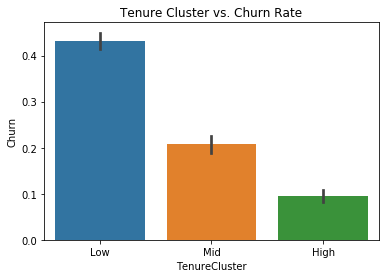

In [21]:
ax = sns.barplot(x='TenureCluster', y='Churn', data=df_data)
ax.set(title='Tenure Cluster vs. Churn Rate');

#### Monthly Charges
This is how it looks after applying the same for Monthly & Total Charges:

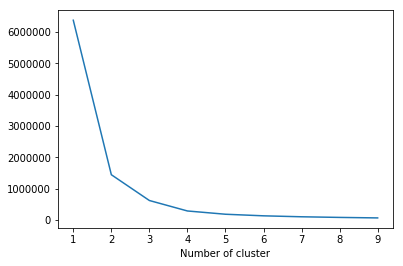

In [22]:
# check appopriate number of clusters
gk.elbow_method(df_data[['MonthlyCharges']])

According to elbow method, for MonthlyCharges we optimal choice is 3 clusters. We could go with other number if business requires so.

In [23]:
# calculate tenure cluster for each customer
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargesCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

# order cluster numbers in ascending order based on mean of group tenure 
df_data = gk.order_cluster('MonthlyChargesCluster', 'tenure', df_data, True)

# assign labels to tenure cluster
df_data['MonthlyChargesCluster'] = df_data["MonthlyChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [24]:
df_data.groupby('MonthlyChargesCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargesCluster,,,,,,,,
High,2912.0,39.717720,23.984937,0.0,17.0,41.0,63.0,72.0
Low,2239.0,25.930326,23.381947,0.0,4.0,18.0,46.0,72.0
Mid,1892.0,28.686047,23.827175,0.0,7.0,23.0,49.0,72.0


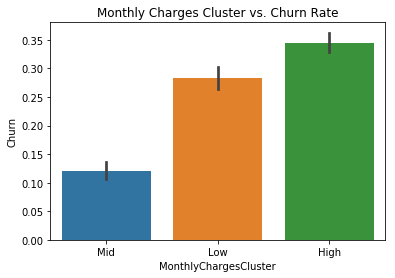

In [25]:
ax = sns.barplot(x='MonthlyChargesCluster', y='Churn', data=df_data)
ax.set(title='Monthly Charges Cluster vs. Churn Rate');

#### Total Charges
Total charges after converting to numeric hace few NA values. Those are customers that just signed up and didn't receice their first invoice yet or only received single invoice.

In [26]:
# coerce to numeric
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')

In [27]:
# check missing data
df_missing = df_data.loc[df_data['TotalCharges'].isnull(), ['tenure', 'MonthlyCharges','TotalCharges']]
df_missing

,tenure,MonthlyCharges,TotalCharges
92,0,20.25,NaN
138,0,25.75,NaN
425,0,19.85,NaN
488,0,25.35,NaN
566,0,20.00,NaN
681,0,19.70,NaN
1977,0,52.55,NaN
2116,0,56.05,NaN
3016,0,73.35,NaN
3029,0,61.90,NaN


In [28]:
# fill TotalCharges with MonthlyCharges
df_data['TotalCharges'] = df_data['TotalCharges'].fillna(value=df_data['MonthlyCharges'])

In [29]:
# check 
df_data.loc[df_missing.index, ['tenure', 'MonthlyCharges','TotalCharges']]

,tenure,MonthlyCharges,TotalCharges
92,0,20.25,20.25
138,0,25.75,25.75
425,0,19.85,19.85
488,0,25.35,25.35
566,0,20.00,20.00
681,0,19.70,19.70
1977,0,52.55,52.55
2116,0,56.05,56.05
3016,0,73.35,73.35
3029,0,61.90,61.90


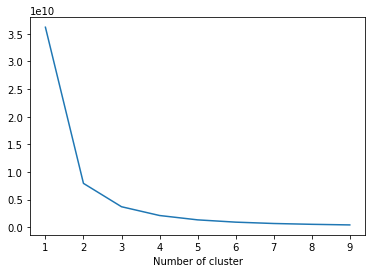

In [30]:
# check appopriate number of clusters
gk.elbow_method(df_data[['TotalCharges']])

According to elbow method, for MonthlyCharges we optimal choice is 3 clusters. We could go with other number if business requires so.

In [31]:
# calculate tenure cluster for each customer
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargesCluster'] = kmeans.predict(df_data[['TotalCharges']])

# order cluster numbers in ascending order based on mean of group tenure 
df_data = gk.order_cluster('TotalChargesCluster', 'tenure', df_data, True)

# assign labels to tenure cluster
df_data['TotalChargesCluster'] = df_data["TotalChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

In [32]:
df_data.groupby('TotalChargesCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargesCluster,,,,,,,,
High,1259.0,64.373312,7.420728,43.0,59.0,66.0,71.0,72.0
Low,4171.0,18.173100,19.185982,0.0,3.0,12.0,24.0,72.0
Mid,1613.0,44.106634,13.433636,19.0,33.0,43.0,54.0,72.0


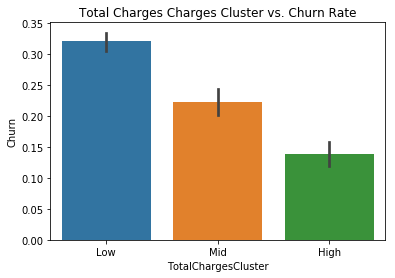

In [33]:
ax = sns.barplot(x='TotalChargesCluster', y='Churn', data=df_data)
ax.set(title='Total Charges Charges Cluster vs. Churn Rate');

### Categorical Columns
Before using categorical columns we need to convert them from lables to numbers. Two approaches are availiable:
* Label Encoder converts categorical columns to numerical by simply assigning integers to distinct values. For instance, the column gender has two values: Female & Male. Label encoder will convert it to 1 and 0.
* get_dummies() method creates new columns out of categorical ones by assigning 0 & 1s

Let's use both to handle remaining columns.

In [34]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customerID               7043 non-null object
gender                   7043 non-null object
SeniorCitizen            7043 non-null int64
Partner                  7043 non-null object
Dependents               7043 non-null object
tenure                   7043 non-null int64
PhoneService             7043 non-null object
MultipleLines            7043 non-null object
InternetService          7043 non-null object
OnlineSecurity           7043 non-null object
OnlineBackup             7043 non-null object
DeviceProtection         7043 non-null object
TechSupport              7043 non-null object
StreamingTV              7043 non-null object
StreamingMovies          7043 non-null object
Contract                 7043 non-null object
PaperlessBilling         7043 non-null object
PaymentMethod            7043 non-null object
MonthlyCharges           7043 non-null float64
TotalCharges        

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in df_data.select_dtypes(include='object').columns:
    if column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            #apply one hot encoding
            df_data = pd.get_dummies(df_data, columns=[column]) 

Check out how the data looks like for the selected columns:

In [36]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 51 columns):
customerID                                 7043 non-null object
gender                                     7043 non-null int32
SeniorCitizen                              7043 non-null int64
Partner                                    7043 non-null int32
Dependents                                 7043 non-null int32
tenure                                     7043 non-null int64
PhoneService                               7043 non-null int32
PaperlessBilling                           7043 non-null int32
MonthlyCharges                             7043 non-null float64
TotalCharges                               7043 non-null float64
Churn                                      7043 non-null int64
MultipleLines_No                           7043 non-null uint8
MultipleLines_No phone service             7043 non-null uint8
MultipleLines_Yes                          7043 non-null uint8
Intern

In [37]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


As we can see easily, gender & Partner columns became numerical ones, and we have three new columns for TenureCluster.

It is time to fit a logistic regression model and extract insights to make better business decisions.

## Logistic Regression
Predicting churn is a binary classification problem. Customers either churn or retain in a given period. Along with being a robust model, Logistic Regression provides interpretable outcomes too. As we did before, let’s sort out our steps to follow for building a Logistic Regression model:
1. Prepare the data (inputs for the model)
1. Fit the model and see the model summary


In [38]:
# remove unwanted characters from column names
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [39]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

And the summary looks like below:

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                            GLM   Df Residuals:                     7013
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2901.2
Date:                Thu, 12 Dec 2019   Deviance:                       5802.4
Time:                        17:09:20   Pearson chi2:                 7.61e+03
No. Iterations:                   100   Covariance Type:             nonrobust
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.2509      0.276      0.908 

We have two important outcomes from this report. When you prepare a Churn Prediction model, you will be faced with the questions below:
1. Which characteristics make customers churn or retain?
1. What are the most critical ones? What should we focus on?

For the first question, you should look at the 4th column (P>|z|). If the absolute p-value is smaller than 0.05, it means, that feature affects Churn in a statistically significant way. Examples are:
* SeniorCitizen
* InternetService_DSL
* OnlineSecurity_NO

Then the second question. We want to reduce the Churn Rate, where we should start? The scientific version of this question is;

> _Which feature will bring the best ROI if I increase/decrease it by one unit?_

That question can be answered by looking at the coef column. Exponential coef gives us the expected change in Churn Rate if we change it by one unit.  If we apply the code below, we will see the transformed version of all coefficients:

In [41]:
np.exp(res.params)

Intercept                                  1.285160
gender                                     0.975395
SeniorCitizen                              1.250605
Partner                                    1.001054
Dependents                                 0.870603
tenure                                     0.937642
PhoneService                               1.257575
PaperlessBilling                           1.415616
MonthlyCharges                             0.966963
TotalCharges                               1.000126
MultipleLines_No                           0.893466
MultipleLines_No_phone_service             1.021935
MultipleLines_Yes                          1.407524
InternetService_DSL                        0.551151
InternetService_Fiber_optic                2.834684
InternetService_No                         0.822587
OnlineSecurity_No                          1.386373
OnlineSecurity_No_internet_service         0.822587
OnlineSecurity_Yes                         1.126925
OnlineBackup

As an example, one unit change in Monthly Charge (coef. 0.965881) means ~3.4% improvement in the odds for churning if we keep everything else constant. From the table above, we can quickly identify which features are more important.
Now, everything is ready for building our classification model.

## Binary Classification Model with XGBoost
To fit XGBoost to our data, we should prepare features (X) and label(y) sets and do the train & test split.

In [42]:
# create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn

In [43]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [44]:
#building the model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.82


By using this simple model, we have achieved 83% accuracy,

Our actual Churn Rate in the dataset was 26.5% (reflects as 73.5% for baseline model performance). This shows our model is a useful one. Better to check our classification model to see where exactly our model fails.

In [45]:
y_pred = xgb_model.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       265
           1       0.69      0.53      0.60        88

   micro avg       0.82      0.82      0.82       353
   macro avg       0.77      0.73      0.74       353
weighted avg       0.82      0.82      0.82       353



We can interpret the report above as if our model tells us, 100 customers will churn, 70 of it will churn (0.70 precision). And actually, there are around 170 customers who will churn (0.58 recall). Especially recall is the main problem here, and we can improve our model’s overall performance by:
* Adding more data (we have around 2000 rows for this example)
* Adding more features
* More feature engineering
* Trying other models
* Hyper-parameter tuning

Moving forward, let’s see how our model works in detail. First off, we want to know which features our model exactly used from the dataset. Also, which were the most important ones?
For addressing this question, we can use the code below:

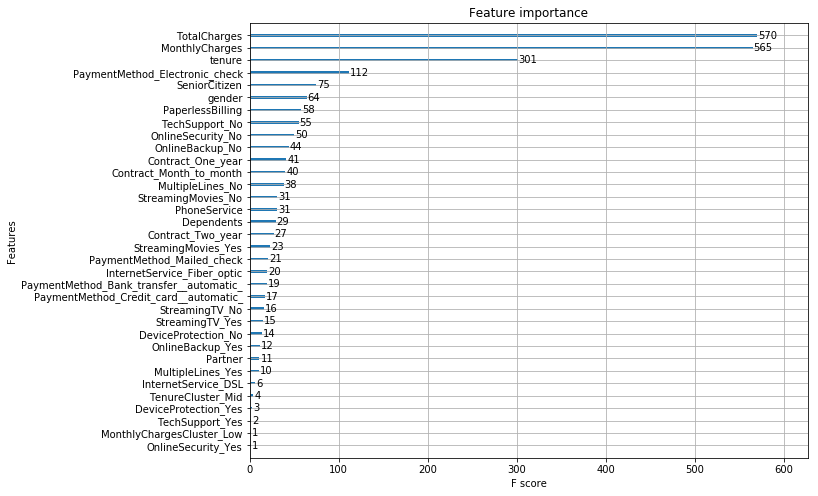

In [47]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

We can see that our model assigned more importance to **TotalCharges** and **MonthlyCharges** compared to others.

Finally, the best way to use this model is assigning Churn Probability for each customer, create segments, and build strategies on top of that. Below we get the churn probability from our model:

In [48]:
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [49]:
df_data[['customerID', 'proba']].head()

,customerID,proba
0,7590-VHVEG,0.631970
1,6713-OKOMC,0.189523
2,7469-LKBCI,0.013183
3,8779-QRDMV,0.885242
4,1680-VDCWW,0.034147


Now we know if there are likely to churn customers in our best segments and we can build actions based on it!